In [ ]:
import numpy as np
import cv2 as cv
import os
from google.colab.patches import cv2_imshow
from queue import PriorityQueue

class Patch:
    def __init__(self, coords, patchRadius, image, confidence, filled, fillFront):
        self.coords = coords
        self.patchRadius = patchRadius
        self.image = image
        self.confidence = confidence
        self.filled = filled
        self.fillFront = fillFront
        self.priority = self.computePriority()

    def getWindow(self, img):
        row, col = self.coords
        r = self.patchRadius
        return img[row-r:row+r+1, col-r:col+r+1]

    def valid(self, otherPatch):
        return np.array_equal(self.getWindow(self.filled), otherPatch.getWindow(otherPatch.getFilled()))

    def setWindow(self, patch, img, validMask):
        row, col = self.coords
        r = self.patchRadius
        img[row-r:row+r+1, col-r:col+r+1] = patch * validMask

    def computePriority(self):
        return np.sum(self.getWindow(self.confidence))

    def getCoords(self):
        return self.coords

    def getRadius(self):
        return self.patchRadius

    def getImage(self):
        return self.image

    def getFilled(self):
        return self.filled

    def getC(self):
        return self.getWindow(self.confidence)

    def getSize(self):
        return 2 * self.patchRadius + 1

    def outerBorderCoords(self, image):
        row, col = self.coords
        r = self.patchRadius
        outer_coords = []
        for i in range(-r, r + 1):
            if row - r >= 0:
                outer_coords.append((row - r, col + i))
            if row + r < image.shape[0]:
                outer_coords.append((row + r, col + i))
            if col - r >= 0:
                outer_coords.append((row + i, col - r))
            if col + r < image.shape[1]:
                outer_coords.append((row + i, col + r))
        return outer_coords


class Inpainting:
    def __init__(self, source, mask, patchRadius):
        self.source = source
        self.mask = mask
        self.fillFront = None
        self.confidence = None
        self.boundary = None
        self.filled = np.uint8(self.mask > 0) * 255
        self.unfilled = np.uint8(self.mask == 0) * 255
        self.iteration = 0
        self.patchRadius = patchRadius
        self.inpainted = self.source.copy()
        for i in range(0, 3):
            self.inpainted[:, :, i] *= (self.filled > 0)
        boundaries, _ = cv.findContours(self.unfilled, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
        self.boundaryIterator = iter(boundaries[0])
        self.confidence = np.zeros_like(self.filled, dtype=np.uint8)
        self.confidence[self.filled == 255] = 1
        self.initializeDatabase()

    def inpaint(self):
        try:
            self.boundary = next(self.boundaryIterator)
            self.fillFront = np.zeros_like(self.filled, dtype=np.uint8)
            cv.drawContours(self.fillFront, [self.boundary], -1, 255)

            self.deltaOmega = PriorityQueue()
            print(f"Boundary points: {self.boundary}")  # Debugging print statement
            for point in self.boundary:
                print(f"Point: {point}")  # Debugging print statement
                coords = (point[1], point[0])  # Directly use point values
                p = Patch(coords, self.patchRadius, self.inpainted, self.confidence, self.filled, self.fillFront)
                priority = max(-p.priority, -1e10)  # Ensure priority is within a reasonable range
                self.deltaOmega.put((priority, p))
        except StopIteration:
            return True

        while not self.deltaOmega.empty():
            _, psi = self.deltaOmega.get()
            bestRow, bestCol = self.match(psi)
            psiMatch = Patch((bestRow, bestCol), self.patchRadius, self.inpainted, self.confidence, self.filled, self.fillFront)
            psi.setWindow(psiMatch.getWindow(psiMatch.getImage()), self.inpainted, psi.valid(psiMatch))
            psi.setWindow(psi.valid(psiMatch) * psi.getC(), self.confidence, psi.valid(psiMatch))
            psi.setWindow(255 * np.ones_like(psi.getWindow(psi.getFilled())), self.filled, np.ones((psi.getSize(), psi.getSize())))
            psi.setWindow(np.zeros_like(psi.getWindow(psi.getFilled())), self.fillFront, np.ones((psi.getSize(), psi.getSize())))

            borderCoords = psi.outerBorderCoords(self.inpainted)
            addToFillFront = lambda x: (self.fillFront[x[0], x[1]] == 0 and self.filled[x[0], x[1]] == 0)
            newFillFrontCoords = filter(addToFillFront, borderCoords)
            for row, col in newFillFrontCoords:
                self.fillFront[row, col] = 255
                newPsi = Patch((row, col), self.patchRadius, self.inpainted, self.confidence, self.filled, self.fillFront)
                priority = max(-newPsi.priority, -1e10)  # Ensure priority is within a reasonable range
                self.deltaOmega.put((priority, newPsi))

            tempQueue = PriorityQueue()
            while not self.deltaOmega.empty():
                _, tempPsi = self.deltaOmega.get()
                row, col = tempPsi.getCoords()
                if not self.filled[row, col]:
                    tempPsi.setImage(self.inpainted)
                    tempPsi.setConfidence(self.confidence)
                    tempPsi.setFilled(self.filled)
                    tempPsi.setFillFront(self.fillFront)
                    tempPsi.computePriority()
                    priority = max(-tempPsi.priority, -1e10)  # Ensure priority is within a reasonable range
                    tempQueue.put((priority, tempPsi))
            self.deltaOmega = tempQueue
            self.iteration += 1
            print(f"Done iteration {self.iteration}")
        return False

    def initializeDatabase(self):
        patchSize = self.patchRadius * 2 + 1
        kernel = np.ones((patchSize, patchSize))
        channels = self.inpainted.shape[2]

        validRows = self.inpainted.shape[0] - 2 * self.patchRadius
        validCols = self.inpainted.shape[1] - 2 * self.patchRadius

        v = self.filled.copy()
        v[v == 255] = 1
        validFilled = cv.erode(v, kernel, iterations=1)
        validBorder = np.zeros_like(validFilled)
        validBorder[self.patchRadius:self.patchRadius + validRows, self.patchRadius:self.patchRadius + validCols] = 1
        valid = validBorder * validFilled
        validIndices = np.argwhere(valid == 1)
        self.patchIndices = validIndices

        patchDB = np.zeros((len(validIndices), (np.square(patchSize) * channels)), dtype=np.uint8)
        for i in range(len(validIndices)):
            row, col = validIndices[i]
            patchDB[i, :] = self.inpainted[row - self.patchRadius:row + self.patchRadius + 1, col - self.patchRadius:col + self.patchRadius + 1, :].flatten()
        self.patchDatabase = patchDB

    def match(self, patch):
        windowVector = patch.getWindow(patch.getImage()).flatten()[np.newaxis, :]
        database = self.patchDatabase.copy()
        database[:, windowVector[0] == 0] = 0
        ssd = np.sum(np.square(database - windowVector), axis=1)
        argmin = np.argmin(ssd)
        return self.patchIndices[argmin]

    def getInpainted(self):
        return self.inpainted


def read_image(path, flags=cv.IMREAD_COLOR):
    return cv.imread(path, flags)

def main(source_path, mask_path, output_path, patch_radius):
    source = read_image(source_path)
    mask = read_image(mask_path, cv.IMREAD_GRAYSCALE)
    assert source is not None
    assert mask is not None

    inpainting = Inpainting(source, mask, patch_radius)
    done = False
    while not done:
        done = inpainting.inpaint()

    cv2_imshow(inpainting.getInpainted())
    cv.imwrite(output_path, inpainting.getInpainted())


# Usage example
source_path = '/content/source.png'  # Replace with your image path
mask_path = '/content/mask.png'      # Replace with your mask path
output_path = '/content/out.png'  # Replace with your output path
patch_radius = 5  # Set the patch radius as needed

main(source_path, mask_path, output_path, patch_radius)


ValueError: operands could not be broadcast together with shapes (332,500) (267,400) (332,500) 

In [ ]:
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow
from queue import PriorityQueue

# Patch and Inpainting classes definitions here ...


def read_image(path, flags=cv.IMREAD_COLOR):
    return cv.imread(path, flags)


def main(source_path, mask_path, output_path, patch_radius):
    source = read_image(source_path)
    mask = read_image(mask_path, cv.IMREAD_GRAYSCALE)
    assert source is not None
    assert mask is not None

    inpainting = Inpainting(source, mask, patch_radius)
    done = False
    while not done:
        done = inpainting.inpaint()

    inpainted_image = inpainting.getInpainted()

    # Resize images for display (optional)
    source_resized = cv.resize(source, (400, 400))
    inpainted_resized = cv.resize(inpainted_image, (400, 400))

    # Create a combined image for display
    combined_image = np.hstack((source_resized, inpainted_resized))

    # Display the images
    cv2_imshow(combined_image)

    # Save the inpainted image
    cv.imwrite(output_path, inpainted_image)


# Usage example
source_path = '/content/source.png'  # Replace with your image path
mask_path = '/content/mask.png'      # Replace with your mask path
output_path = '/content/output_image.jpg'  # Replace with your output path
patch_radius = 5  # Set the patch radius as needed

main(source_path, mask_path, output_path, patch_radius)


AttributeError: 'Inpainting' object has no attribute 'processBoundaries'

Boundary points: [[301 135]]
Point: [301 135]


<ipython-input-8-e1b1f3ca0800>:98: RuntimeWarning: overflow encountered in scalar negative
  priority = max(-p.priority, -1e10)  # Ensure priority is within a reasonable range


Done iteration 1
Boundary points: [[301 136]]
Point: [301 136]
Done iteration 2
Boundary points: [[301 137]]
Point: [301 137]
Done iteration 3
Boundary points: [[301 138]]
Point: [301 138]
Done iteration 4
Boundary points: [[301 139]]
Point: [301 139]
Done iteration 5
Boundary points: [[301 140]]
Point: [301 140]
Done iteration 6
Boundary points: [[301 141]]
Point: [301 141]
Done iteration 7
Boundary points: [[301 142]]
Point: [301 142]
Done iteration 8
Boundary points: [[302 142]]
Point: [302 142]
Done iteration 9
Boundary points: [[303 142]]
Point: [303 142]
Done iteration 10
Boundary points: [[304 142]]
Point: [304 142]
Done iteration 11
Boundary points: [[305 142]]
Point: [305 142]
Done iteration 12
Boundary points: [[306 142]]
Point: [306 142]
Done iteration 13
Boundary points: [[307 142]]
Point: [307 142]
Done iteration 14
Boundary points: [[308 142]]
Point: [308 142]
Done iteration 15
Boundary points: [[308 141]]
Point: [308 141]
Done iteration 16
Boundary points: [[308 140]]
Po

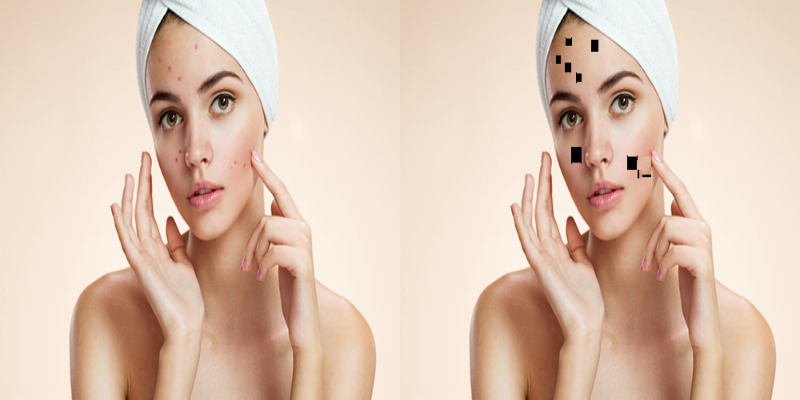

In [ ]:
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow
from queue import PriorityQueue

class Patch:
    def __init__(self, coords, patchRadius, image, confidence, filled, fillFront):
        self.coords = coords
        self.patchRadius = patchRadius
        self.image = image
        self.confidence = confidence
        self.filled = filled
        self.fillFront = fillFront
        self.priority = self.computePriority()

    def getWindow(self, img):
        row, col = self.coords
        r = self.patchRadius
        return img[row-r:row+r+1, col-r:col+r+1]

    def valid(self, otherPatch):
        return np.array_equal(self.getWindow(self.filled), otherPatch.getWindow(otherPatch.getFilled()))

    def setWindow(self, patch, img, validMask):
        row, col = self.coords
        r = self.patchRadius
        img[row-r:row+r+1, col-r:col+r+1] = patch * validMask

    def computePriority(self):
        return np.sum(self.getWindow(self.confidence))

    def getCoords(self):
        return self.coords

    def getRadius(self):
        return self.patchRadius

    def getImage(self):
        return self.image

    def getFilled(self):
        return self.filled

    def getC(self):
        return self.getWindow(self.confidence)

    def getSize(self):
        return 2 * self.patchRadius + 1

    def outerBorderCoords(self, image):
        row, col = self.coords
        r = self.patchRadius
        outer_coords = []
        for i in range(-r, r + 1):
            if row - r >= 0:
                outer_coords.append((row - r, col + i))
            if row + r < image.shape[0]:
                outer_coords.append((row + r, col + i))
            if col - r >= 0:
                outer_coords.append((row + i, col - r))
            if col + r < image.shape[1]:
                outer_coords.append((row + i, col + r))
        return outer_coords


class Inpainting:
    def __init__(self, source, mask, patchRadius):
        self.source = source
        self.mask = mask
        self.fillFront = None
        self.confidence = None
        self.boundary = None
        self.filled = np.uint8(self.mask > 0) * 255
        self.unfilled = np.uint8(self.mask == 0) * 255
        self.iteration = 0
        self.patchRadius = patchRadius
        self.inpainted = self.source.copy()
        for i in range(0, 3):
            self.inpainted[:, :, i] *= (self.filled > 0)
        boundaries, _ = cv.findContours(self.unfilled, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
        self.boundaryIterator = iter(boundaries[0])
        self.confidence = np.zeros_like(self.filled, dtype=np.uint8)
        self.confidence[self.filled == 255] = 1
        self.initializeDatabase()

    def inpaint(self):
        try:
            self.boundary = next(self.boundaryIterator)
            self.fillFront = np.zeros_like(self.filled, dtype=np.uint8)
            cv.drawContours(self.fillFront, [self.boundary], -1, 255)

            self.deltaOmega = PriorityQueue()
            print(f"Boundary points: {self.boundary}")  # Debugging print statement
            for point in self.boundary:
                print(f"Point: {point}")  # Debugging print statement
                coords = (point[1], point[0])  # Directly use point values
                p = Patch(coords, self.patchRadius, self.inpainted, self.confidence, self.filled, self.fillFront)
                priority = max(-p.priority, -1e10)  # Ensure priority is within a reasonable range
                self.deltaOmega.put((priority, p))
        except StopIteration:
            return True

        while not self.deltaOmega.empty():
            _, psi = self.deltaOmega.get()
            bestRow, bestCol = self.match(psi)
            psiMatch = Patch((bestRow, bestCol), self.patchRadius, self.inpainted, self.confidence, self.filled, self.fillFront)
            psi.setWindow(psiMatch.getWindow(psiMatch.getImage()), self.inpainted, psi.valid(psiMatch))
            psi.setWindow(psi.valid(psiMatch) * psi.getC(), self.confidence, psi.valid(psiMatch))
            psi.setWindow(255 * np.ones_like(psi.getWindow(psi.getFilled())), self.filled, np.ones((psi.getSize(), psi.getSize())))
            psi.setWindow(np.zeros_like(psi.getWindow(psi.getFilled())), self.fillFront, np.ones((psi.getSize(), psi.getSize())))

            borderCoords = psi.outerBorderCoords(self.inpainted)
            addToFillFront = lambda x: (self.fillFront[x[0], x[1]] == 0 and self.filled[x[0], x[1]] == 0)
            newFillFrontCoords = filter(addToFillFront, borderCoords)
            for row, col in newFillFrontCoords:
                self.fillFront[row, col] = 255
                newPsi = Patch((row, col), self.patchRadius, self.inpainted, self.confidence, self.filled, self.fillFront)
                priority = max(-newPsi.priority, -1e10)  # Ensure priority is within a reasonable range
                self.deltaOmega.put((priority, newPsi))

            tempQueue = PriorityQueue()
            while not self.deltaOmega.empty():
                _, tempPsi = self.deltaOmega.get()
                row, col = tempPsi.getCoords()
                if not self.filled[row, col]:
                    tempPsi.setImage(self.inpainted)
                    tempPsi.setConfidence(self.confidence)
                    tempPsi.setFilled(self.filled)
                    tempPsi.setFillFront(self.fillFront)
                    tempPsi.computePriority()
                    priority = max(-tempPsi.priority, -1e10)  # Ensure priority is within a reasonable range
                    tempQueue.put((priority, tempPsi))
            self.deltaOmega = tempQueue
            self.iteration += 1
            print(f"Done iteration {self.iteration}")
        return False

    def initializeDatabase(self):
        patchSize = self.patchRadius * 2 + 1
        kernel = np.ones((patchSize, patchSize))
        channels = self.inpainted.shape[2]

        validRows = self.inpainted.shape[0] - 2 * self.patchRadius
        validCols = self.inpainted.shape[1] - 2 * self.patchRadius

        v = self.filled.copy()
        v[v == 255] = 1
        validFilled = cv.erode(v, kernel, iterations=1)
        validBorder = np.zeros_like(validFilled)
        validBorder[self.patchRadius:self.patchRadius + validRows, self.patchRadius:self.patchRadius + validCols] = 1
        valid = validBorder * validFilled
        validIndices = np.argwhere(valid == 1)
        self.patchIndices = validIndices

        patchDB = np.zeros((len(validIndices), (np.square(patchSize) * channels)), dtype=np.uint8)
        for i in range(len(validIndices)):
            row, col = validIndices[i]
            patchDB[i, :] = self.inpainted[row - self.patchRadius:row + self.patchRadius + 1, col - self.patchRadius:col + self.patchRadius + 1, :].flatten()
        self.patchDatabase = patchDB

    def match(self, patch):
        windowVector = patch.getWindow(patch.getImage()).flatten()[np.newaxis, :]
        database = self.patchDatabase.copy()
        database[:, windowVector[0] == 0] = 0
        ssd = np.sum(np.square(database - windowVector), axis=1)
        argmin = np.argmin(ssd)
        return self.patchIndices[argmin]

    def getInpainted(self):
        return self.inpainted


def read_image(path, flags=cv.IMREAD_COLOR):
    return cv.imread(path, flags)


def main(source_path, mask_path, output_path, patch_radius):
    source = read_image(source_path)
    mask = read_image(mask_path, cv.IMREAD_GRAYSCALE)
    assert source is not None
    assert mask is not None

    inpainting = Inpainting(source, mask, patch_radius)
    done = False
    while not done:
        done = inpainting.inpaint()

    inpainted_image = inpainting.getInpainted()

    # Display the source and inpainted images side by side
    combined_image = np.hstack((source, inpainted_image))

    # Resize for display (optional)
    combined_image = cv.resize(combined_image, (800, 400))

    # Display the images
    cv2_imshow(combined_image)

    # Save the inpainted image
    cv.imwrite(output_path, inpainted_image)


# Usage example
source_path = '/content/source.png'  # Replace with your image path
mask_path = '/content/mask.png'      # Replace with your mask path
output_path = '/content/output_image.jpg'  # Replace with your output path
patch_radius = 5  # Set the patch radius as needed

main(source_path, mask_path, output_path, patch_radius)


Boundary points: [[301 135]]
Point: [301 135]


<ipython-input-2-b7a4171ba358>:97: RuntimeWarning: overflow encountered in scalar negative
  priority = max(-p.priority, -1e10)  # Ensure priority is within a reasonable range


Done iteration 1
Boundary points: [[301 136]]
Point: [301 136]
Done iteration 2
Boundary points: [[301 137]]
Point: [301 137]
Done iteration 3
Boundary points: [[301 138]]
Point: [301 138]
Done iteration 4
Boundary points: [[301 139]]
Point: [301 139]
Done iteration 5
Boundary points: [[301 140]]
Point: [301 140]
Done iteration 6
Boundary points: [[301 141]]
Point: [301 141]
Done iteration 7
Boundary points: [[301 142]]
Point: [301 142]
Done iteration 8
Boundary points: [[302 142]]
Point: [302 142]
Done iteration 9
Boundary points: [[303 142]]
Point: [303 142]
Done iteration 10
Boundary points: [[304 142]]
Point: [304 142]
Done iteration 11
Boundary points: [[305 142]]
Point: [305 142]
Done iteration 12
Boundary points: [[306 142]]
Point: [306 142]
Done iteration 13
Boundary points: [[307 142]]
Point: [307 142]
Done iteration 14
Boundary points: [[308 142]]
Point: [308 142]
Done iteration 15
Boundary points: [[308 141]]
Point: [308 141]
Done iteration 16
Boundary points: [[308 140]]
Po

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
<ipython-input-2-b7a4171ba358>:201: RuntimeWarning: invalid value encountered in cast
  inpainted_image[row, col] = surrounding_skin_color.astype(np.uint8)


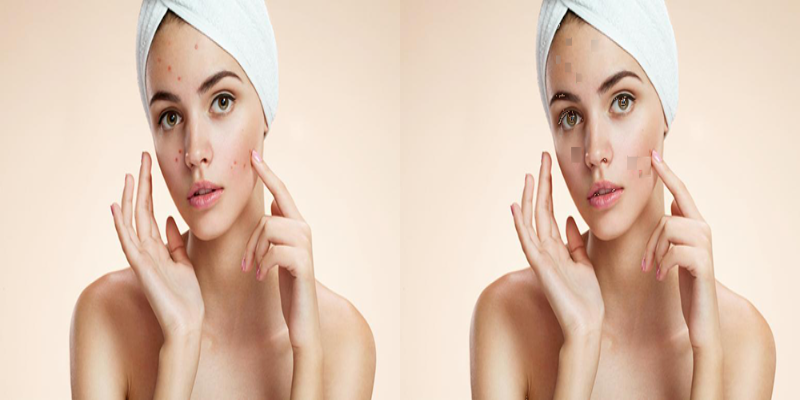

Boundary points: [[301 135]]
Point: [301 135]
Done iteration 1
Boundary points: [[301 136]]
Point: [301 136]
Done iteration 2
Boundary points: [[301 137]]
Point: [301 137]
Done iteration 3
Boundary points: [[301 138]]
Point: [301 138]
Done iteration 4
Boundary points: [[301 139]]
Point: [301 139]
Done iteration 5
Boundary points: [[301 140]]
Point: [301 140]
Done iteration 6
Boundary points: [[301 141]]
Point: [301 141]
Done iteration 7
Boundary points: [[301 142]]
Point: [301 142]
Done iteration 8
Boundary points: [[302 142]]
Point: [302 142]
Done iteration 9
Boundary points: [[303 142]]
Point: [303 142]
Done iteration 10
Boundary points: [[304 142]]
Point: [304 142]
Done iteration 11
Boundary points: [[305 142]]
Point: [305 142]
Done iteration 12
Boundary points: [[306 142]]
Point: [306 142]
Done iteration 13
Boundary points: [[307 142]]
Point: [307 142]
Done iteration 14
Boundary points: [[308 142]]
Point: [308 142]
Done iteration 15
Boundary points: [[308 141]]
Point: [308 141]
Don

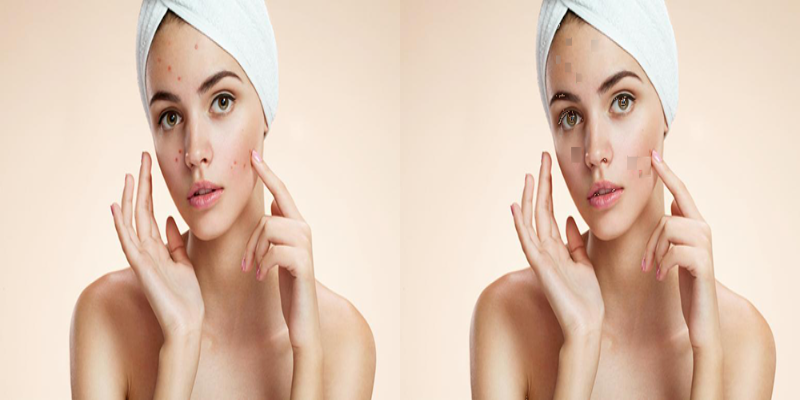

Boundary points: [[301 135]]
Point: [301 135]
Done iteration 1
Boundary points: [[301 136]]
Point: [301 136]
Done iteration 2
Boundary points: [[301 137]]
Point: [301 137]
Done iteration 3
Boundary points: [[301 138]]
Point: [301 138]
Done iteration 4
Boundary points: [[301 139]]
Point: [301 139]
Done iteration 5
Boundary points: [[301 140]]
Point: [301 140]
Done iteration 6
Boundary points: [[301 141]]
Point: [301 141]
Done iteration 7
Boundary points: [[301 142]]
Point: [301 142]
Done iteration 8
Boundary points: [[302 142]]
Point: [302 142]
Done iteration 9
Boundary points: [[303 142]]
Point: [303 142]
Done iteration 10
Boundary points: [[304 142]]
Point: [304 142]
Done iteration 11
Boundary points: [[305 142]]
Point: [305 142]
Done iteration 12
Boundary points: [[306 142]]
Point: [306 142]
Done iteration 13
Boundary points: [[307 142]]
Point: [307 142]
Done iteration 14
Boundary points: [[308 142]]
Point: [308 142]
Done iteration 15
Boundary points: [[308 141]]
Point: [308 141]
Don

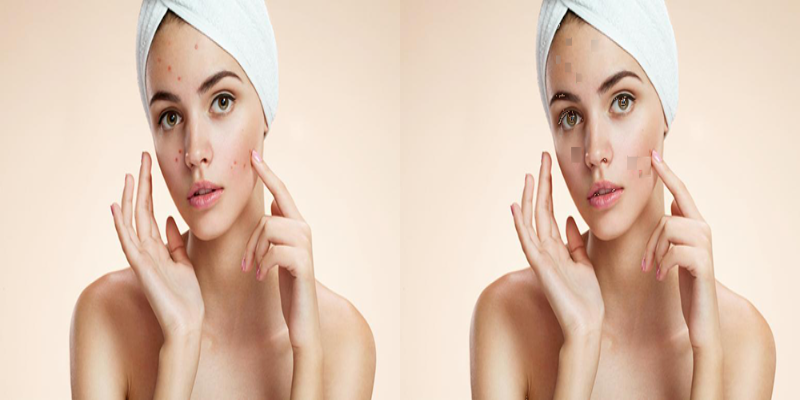

Boundary points: [[301 135]]
Point: [301 135]
Done iteration 1
Boundary points: [[301 136]]
Point: [301 136]
Done iteration 2
Boundary points: [[301 137]]
Point: [301 137]
Done iteration 3
Boundary points: [[301 138]]
Point: [301 138]
Done iteration 4
Boundary points: [[301 139]]
Point: [301 139]
Done iteration 5
Boundary points: [[301 140]]
Point: [301 140]
Done iteration 6
Boundary points: [[301 141]]
Point: [301 141]
Done iteration 7
Boundary points: [[301 142]]
Point: [301 142]
Done iteration 8
Boundary points: [[302 142]]
Point: [302 142]
Done iteration 9
Boundary points: [[303 142]]
Point: [303 142]
Done iteration 10
Boundary points: [[304 142]]
Point: [304 142]
Done iteration 11
Boundary points: [[305 142]]
Point: [305 142]
Done iteration 12
Boundary points: [[306 142]]
Point: [306 142]
Done iteration 13
Boundary points: [[307 142]]
Point: [307 142]
Done iteration 14
Boundary points: [[308 142]]
Point: [308 142]
Done iteration 15
Boundary points: [[308 141]]
Point: [308 141]
Don

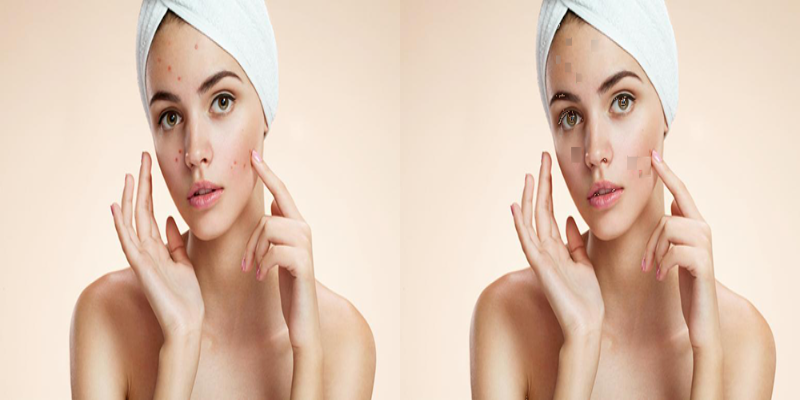

Boundary points: [[301 135]]
Point: [301 135]
Done iteration 1
Boundary points: [[301 136]]
Point: [301 136]
Done iteration 2
Boundary points: [[301 137]]
Point: [301 137]
Done iteration 3
Boundary points: [[301 138]]
Point: [301 138]
Done iteration 4
Boundary points: [[301 139]]
Point: [301 139]
Done iteration 5
Boundary points: [[301 140]]
Point: [301 140]
Done iteration 6
Boundary points: [[301 141]]
Point: [301 141]
Done iteration 7
Boundary points: [[301 142]]
Point: [301 142]
Done iteration 8
Boundary points: [[302 142]]
Point: [302 142]
Done iteration 9
Boundary points: [[303 142]]
Point: [303 142]
Done iteration 10
Boundary points: [[304 142]]
Point: [304 142]
Done iteration 11
Boundary points: [[305 142]]
Point: [305 142]
Done iteration 12
Boundary points: [[306 142]]
Point: [306 142]
Done iteration 13
Boundary points: [[307 142]]
Point: [307 142]
Done iteration 14
Boundary points: [[308 142]]
Point: [308 142]
Done iteration 15
Boundary points: [[308 141]]
Point: [308 141]
Don

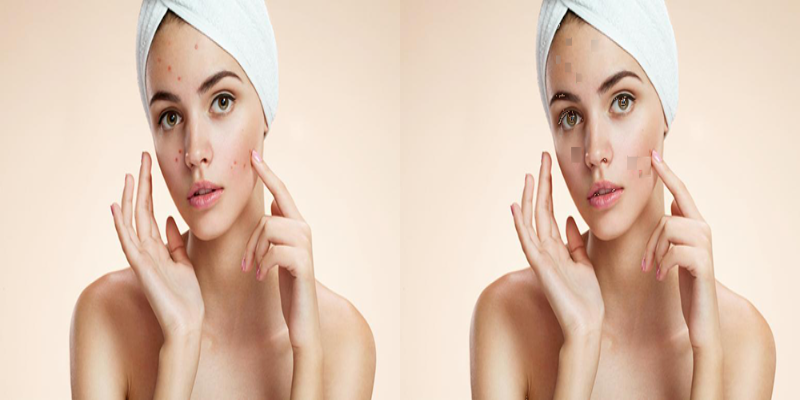

In [2]:
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow
from queue import PriorityQueue

class Patch:
    def __init__(self, coords, patchRadius, image, confidence, filled, fillFront):
        self.coords = coords
        self.patchRadius = patchRadius
        self.image = image
        self.confidence = confidence
        self.filled = filled
        self.fillFront = fillFront
        self.priority = self.computePriority()

    def getWindow(self, img):
        row, col = self.coords
        r = self.patchRadius
        return img[row-r:row+r+1, col-r:col+r+1]

    def valid(self, otherPatch):
        return np.array_equal(self.getWindow(self.filled), otherPatch.getWindow(otherPatch.getFilled()))

    def setWindow(self, patch, img, validMask):
        row, col = self.coords
        r = self.patchRadius
        img[row-r:row+r+1, col-r:col+r+1] = patch * validMask

    def computePriority(self):
        return np.sum(self.getWindow(self.confidence))

    def getCoords(self):
        return self.coords

    def getRadius(self):
        return self.patchRadius

    def getImage(self):
        return self.image

    def getFilled(self):
        return self.filled

    def getC(self):
        return self.getWindow(self.confidence)

    def getSize(self):
        return 2 * self.patchRadius + 1

    def outerBorderCoords(self, image):
        row, col = self.coords
        r = self.patchRadius
        outer_coords = []
        for i in range(-r, r + 1):
            if row - r >= 0:
                outer_coords.append((row - r, col + i))
            if row + r < image.shape[0]:
                outer_coords.append((row + r, col + i))
            if col - r >= 0:
                outer_coords.append((row + i, col - r))
            if col + r < image.shape[1]:
                outer_coords.append((row + i, col + r))
        return outer_coords

class Inpainting:
    def __init__(self, source, mask, patchRadius):
        self.source = source
        self.mask = mask
        self.fillFront = None
        self.confidence = None
        self.boundary = None
        self.filled = np.uint8(self.mask > 0) * 255
        self.unfilled = np.uint8(self.mask == 0) * 255
        self.iteration = 0
        self.patchRadius = patchRadius
        self.inpainted = self.source.copy()
        for i in range(0, 3):
            self.inpainted[:, :, i] *= (self.filled > 0)
        boundaries, _ = cv.findContours(self.unfilled, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
        self.boundaryIterator = iter(boundaries[0])
        self.confidence = np.zeros_like(self.filled, dtype=np.uint8)
        self.confidence[self.filled == 255] = 1
        self.initializeDatabase()

    def inpaint(self):
        try:
            self.boundary = next(self.boundaryIterator)
            self.fillFront = np.zeros_like(self.filled, dtype=np.uint8)
            cv.drawContours(self.fillFront, [self.boundary], -1, 255)

            self.deltaOmega = PriorityQueue()
            print(f"Boundary points: {self.boundary}")  # Debugging print statement
            for point in self.boundary:
                print(f"Point: {point}")  # Debugging print statement
                coords = (point[1], point[0])  # Directly use point values
                p = Patch(coords, self.patchRadius, self.inpainted, self.confidence, self.filled, self.fillFront)
                priority = max(-p.priority, -1e10)  # Ensure priority is within a reasonable range
                self.deltaOmega.put((priority, p))
        except StopIteration:
            return True

        while not self.deltaOmega.empty():
            _, psi = self.deltaOmega.get()
            bestRow, bestCol = self.match(psi)
            psiMatch = Patch((bestRow, bestCol), self.patchRadius, self.inpainted, self.confidence, self.filled, self.fillFront)
            psi.setWindow(psiMatch.getWindow(psiMatch.getImage()), self.inpainted, psi.valid(psiMatch))
            psi.setWindow(psi.valid(psiMatch) * psi.getC(), self.confidence, psi.valid(psiMatch))
            psi.setWindow(255 * np.ones_like(psi.getWindow(psi.getFilled())), self.filled, np.ones((psi.getSize(), psi.getSize())))
            psi.setWindow(np.zeros_like(psi.getWindow(psi.getFilled())), self.fillFront, np.ones((psi.getSize(), psi.getSize())))

            borderCoords = psi.outerBorderCoords(self.inpainted)
            addToFillFront = lambda x: (self.fillFront[x[0], x[1]] == 0 and self.filled[x[0], x[1]] == 0)
            newFillFrontCoords = filter(addToFillFront, borderCoords)
            for row, col in newFillFrontCoords:
                self.fillFront[row, col] = 255
                newPsi = Patch((row, col), self.patchRadius, self.inpainted, self.confidence, self.filled, self.fillFront)
                priority = max(-newPsi.priority, -1e10)  # Ensure priority is within a reasonable range
                self.deltaOmega.put((priority, newPsi))

            tempQueue = PriorityQueue()
            while not self.deltaOmega.empty():
                _, tempPsi = self.deltaOmega.get()
                row, col = tempPsi.getCoords()
                if not self.filled[row, col]:
                    tempPsi.setImage(self.inpainted)
                    tempPsi.setConfidence(self.confidence)
                    tempPsi.setFilled(self.filled)
                    tempPsi.setFillFront(self.fillFront)
                    tempPsi.computePriority()
                    priority = max(-tempPsi.priority, -1e10)  # Ensure priority is within a reasonable range
                    tempQueue.put((priority, tempPsi))
            self.deltaOmega = tempQueue
            self.iteration += 1
            print(f"Done iteration {self.iteration}")
        return False

    def initializeDatabase(self):
        patchSize = self.patchRadius * 2 + 1
        kernel = np.ones((patchSize, patchSize))
        channels = self.inpainted.shape[2]

        validRows = self.inpainted.shape[0] - 2 * self.patchRadius
        validCols = self.inpainted.shape[1] - 2 * self.patchRadius

        v = self.filled.copy()
        v[v == 255] = 1
        validFilled = cv.erode(v, kernel, iterations=1)
        validBorder = np.zeros_like(validFilled)
        validBorder[self.patchRadius:self.patchRadius + validRows, self.patchRadius:self.patchRadius + validCols] = 1
        valid = validBorder * validFilled
        validIndices = np.argwhere(valid == 1)
        self.patchIndices = validIndices

        patchDB = np.zeros((len(validIndices), (np.square(patchSize) * channels)), dtype=np.uint8)
        for i in range(len(validIndices)):
            row, col = validIndices[i]
            patchDB[i, :] = self.inpainted[row - self.patchRadius:row + self.patchRadius + 1, col - self.patchRadius:col + self.patchRadius + 1, :].flatten()
        self.patchDatabase = patchDB

    def match(self, patch):
        windowVector = patch.getWindow(patch.getImage()).flatten()[np.newaxis, :]
        database = self.patchDatabase.copy()
        database[:, windowVector[0] == 0] = 0
        ssd = np.sum(np.square(database - windowVector), axis=1)
        argmin = np.argmin(ssd)
        return self.patchIndices[argmin]

    def getInpainted(self):
        return self.inpainted




def read_image(path, flags=cv.IMREAD_COLOR):
    return cv.imread(path, flags)

def main(source_path, mask_path, output_path, patch_radius, iterations=5):
    source = read_image(source_path)
    mask = read_image(mask_path, cv.IMREAD_GRAYSCALE)
    assert source is not None
    assert mask is not None

    inpainted_image = None
    for i in range(iterations):
        inpainting = Inpainting(source, mask, patch_radius)
        done = False
        while not done:
            done = inpainting.inpaint()

        inpainted_image = inpainting.getInpainted()

        # Detect locations of pimples (black areas)
        pimples_locations = np.argwhere(inpainted_image == [0, 0, 0])  # Find black pixels

        # Replace each pimple area with surrounding skin color
        for loc in pimples_locations:
            row, col = loc[0], loc[1]
            # Get surrounding skin color by sampling from a larger region
            surrounding_skin_color = np.mean(inpainted_image[row-20:row+20, col-20:col+20], axis=(0, 1))
            # Replace pimple area with surrounding skin color
            inpainted_image[row, col] = surrounding_skin_color.astype(np.uint8)

        # Display the source and inpainted images side by side
        source_resized = cv.resize(source, (400, 400))
        inpainted_resized = cv.resize(inpainted_image, (400, 400))
        combined_image = np.hstack((source_resized, inpainted_resized))

        # Display the images
        cv2_imshow(combined_image)

        # Save the inpainted image
        cv.imwrite(output_path, inpainted_image)

# Usage example
source_path = '/content/source.png'  # Replace with your image path
mask_path = '/content/mask.png'      # Replace with your mask path
output_path = '/content/output_image.jpg'  # Replace with your output path
patch_radius = 5  # Set the patch radius as needed
iterations = 5  # Number of iterations

main(source_path, mask_path, output_path, patch_radius, iterations)


Similarity Score: 98.879%


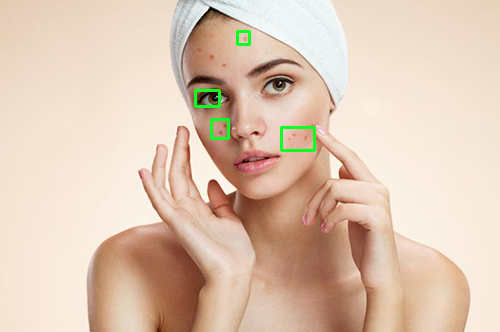

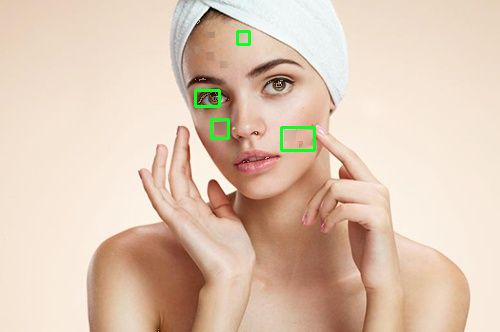

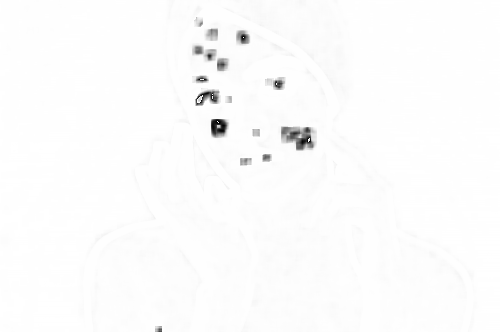

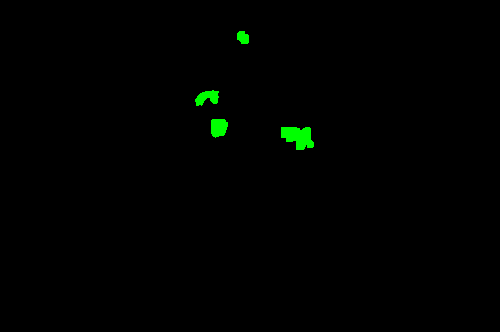

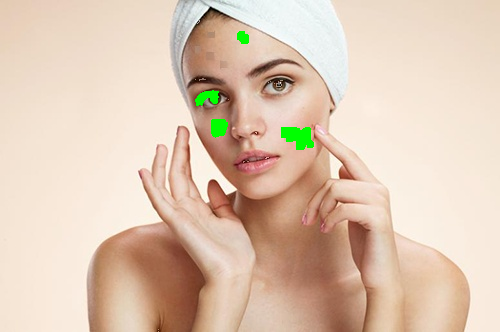

-1

In [4]:
from skimage.metrics import structural_similarity
import cv2
import numpy as np
from google.colab.patches import cv2_imshow # Import cv2_imshow

first = cv2.imread('/content/source.png')
second = cv2.imread('/content/output_image.jpg')

# Convert images to grayscale
first_gray = cv2.cvtColor(first, cv2.COLOR_BGR2GRAY)
second_gray = cv2.cvtColor(second, cv2.COLOR_BGR2GRAY)

# Compute SSIM between two images
score, diff = structural_similarity(first_gray, second_gray, full=True)
print("Similarity Score: {:.3f}%".format(score * 100))

# The diff image contains the actual image differences between the two images
# and is represented as a floating point data type so we must convert the array
# to 8-bit unsigned integers in the range [0,255] before we can use it with OpenCV
diff = (diff * 255).astype("uint8")

# Threshold the difference image, followed by finding contours to
# obtain the regions that differ between the two images
thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]

# Highlight differences
mask = np.zeros(first.shape, dtype='uint8')
filled = second.copy()

for c in contours:
    area = cv2.contourArea(c)
    if area > 100:
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(first, (x, y), (x + w, y + h), (36,255,12), 2)
        cv2.rectangle(second, (x, y), (x + w, y + h), (36,255,12), 2)
        cv2.drawContours(mask, [c], 0, (0,255,0), -1)
        cv2.drawContours(filled, [c], 0, (0,255,0), -1)

cv2_imshow(first) # Use cv2_imshow instead of cv2.imshow
cv2_imshow(second)
cv2_imshow(diff)
cv2_imshow(mask)
cv2_imshow(filled)
cv2.waitKey()